In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import re
import imageio
import cv2
import matplotlib.pyplot as plt
import os
import yaml
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# Settings

In [6]:
train_path = './TrafficSignLocalizationandDetection/train'
valid_path = './TrafficSignLocalizationandDetection/valid'
test_path = './TrafficSignLocalizationandDetection/test'

In [7]:
num_categories = 36

In [8]:
reduced_image_size = (208, 208)

# Preprocessing

## Create Data Frames For Loading Data

In [9]:
raw_train_labels = pd.DataFrame(np.zeros((0, 4 + num_categories)), 
                                columns=['x', 'y', 'w', 'h'] + list(range(1, num_categories + 1)))
raw_train_images = []
raw_test_labels = pd.DataFrame(np.zeros((0, 4 + num_categories)), 
                               columns=['x', 'y', 'w', 'h'] + list(range(1, num_categories + 1)))
raw_test_images = []

## Resize And Denoise Images

In [10]:
def load_images(path):
    images = []
    
    for file in os.listdir(path):
        filename = os.path.join(path, os.fsdecode(file))
        image = cv2.imread(filename)
        # takes a long time to denoise images, only run if you have a lot of time / 
        # extremely fast CPU
        # image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21) 
        image = cv2.resize(image, reduced_image_size)
        images.append(image)
    return np.array(images)

## Loading Images

In [11]:
raw_train_images = np.concatenate([
    load_images(os.path.join(train_path, 'images')),
    load_images(os.path.join(valid_path, 'images')),
])
raw_test_images = load_images(os.path.join(test_path, 'images'))

## Read Labels From File

In [15]:
def load_labels(path):
    labels = pd.DataFrame(np.zeros((0, 40)), columns=['x', 'y', 'w', 'h'] + list(range(1, 37)))
    idx = 0

    for file in os.listdir(path):
        filename = os.path.join(path, os.fsdecode(file))
        file_data = pd.read_csv(filename, sep=' ', header=None)
        file_data.columns = ['cat', 'x', 'y', 'w', 'h']
        cat = file_data['cat'][0]
        new_inst = np.zeros((1, 40))
        new_inst[0][0] = file_data['x'][0]
        new_inst[0][1] = file_data['y'][0]
        new_inst[0][2] = file_data['w'][0]
        new_inst[0][3] = file_data['h'][0]
        new_inst[0][file_data['cat'][0] + 3] = 1
        labels = pd.concat([labels, 
                   pd.DataFrame((new_inst), columns=['x', 'y', 'w', 'h'] + list(range(1, 37)))
                  ])
    return labels

## Load Labels

In [16]:
raw_train_labels = pd.concat([
    load_labels(os.path.join(train_path, 'labels')),
    load_labels(os.path.join(valid_path, 'labels')),
])
raw_test_labels = load_labels(os.path.join(test_path, 'labels'))

# Model Creation

## Creating The Model

Implement the model as originally proposed by the Xception paper by Francois Chollet

In [17]:
input_layer = keras.layers.Input(shape=[reduced_image_size[0], reduced_image_size[1], 3])

conv_1 = keras.layers.Conv2D(32, (3,3), strides=(2,2), activation='elu')(input_layer)
conv_2 = keras.layers.Conv2D(64, (3,3), activation='relu')(conv_1)
drop_1 = keras.layers.Dropout(0.5)(conv_2)

# channel 1/1
conv_3 = keras.layers.Conv2D(128, (1,1), strides=(2,2), activation='elu', padding='same')(drop_1)
# channel 1/2
conv_4 = keras.layers.SeparableConv2D(128, (3,3), padding='same')(drop_1)
conv_5 = keras.layers.SeparableConv2D(128, (3,3), activation='elu', padding='same')(conv_4)
max_pool_1 = keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(conv_5)

concat_1 = keras.layers.add([conv_3, max_pool_1])
bn_2 = keras.layers.BatchNormalization()(concat_1)

# channel 2/1
conv_6 = keras.layers.Conv2D(128, (1,1), strides=(2,2), activation='elu', padding='same')(bn_2)
# channel 2/2
conv_7 = keras.layers.SeparableConv2D(128, (3,3), activation='elu', padding='same')(bn_2)
conv_8 = keras.layers.SeparableConv2D(128, (3,3), activation='elu', padding='same')(conv_7)
max_pool_2 = keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(conv_8)

concat_2 = keras.layers.add([conv_6, max_pool_2])
bn_3 = keras.layers.BatchNormalization()(concat_2)

# channel 3/1
conv_9 = keras.layers.Conv2D(128, (1,1), strides=(2,2), activation='elu', padding='same')(bn_3)
# channel 3/2
conv_10 = keras.layers.SeparableConv2D(128, (3,3), activation='elu', padding='same')(bn_3)
conv_11 = keras.layers.SeparableConv2D(128, (3,3), activation='elu', padding='same')(conv_10)
max_pool_3 = keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(conv_11)

concat_3 = keras.layers.add([conv_9, max_pool_3])
concat_3 = keras.layers.BatchNormalization()(concat_3)

In [18]:
for i in range(8):
    conv_12 = keras.layers.SeparableConv2D(128, (3,3), activation='elu', padding='same')(concat_3)
    conv_13 = keras.layers.SeparableConv2D(128, (3,3), activation='elu', padding='same')(conv_12)
    conv_14 = keras.layers.SeparableConv2D(128, (3,3), activation='elu', padding='same')(conv_13)
    concat_3 = keras.layers.add([concat_3, conv_14])

In [19]:
# channel 4/1
conv_15 = keras.layers.Conv2D(1024, (1,1), (2,2))(concat_3)
# channel 4/2
conv_16 = keras.layers.SeparableConv2D(728, (3,3), activation='elu', padding='same')(concat_3)
conv_17 = keras.layers.SeparableConv2D(1024, (3,3), activation='elu', padding='same')(conv_16)
max_pool_4 = keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(conv_17)

concat_4 = keras.layers.add([conv_15, max_pool_4])

conv_18 = keras.layers.SeparableConv2D(1536, (3,3), activation='elu', padding='same')(concat_4)
conv_19 = keras.layers.SeparableConv2D(2048, (3,3), activation='elu', padding='same')(conv_18)
avg_pool = keras.layers.GlobalAveragePooling2D()(conv_19)

dense_1 = keras.layers.Dense(128, activation='elu')(avg_pool)
dense_2 = keras.layers.Dense(128, activation='elu')(dense_1)
dense_3 = keras.layers.Dense(128)(dense_2)

class_output = keras.layers.Dense(num_categories, activation="softmax")(dense_3)

concat_5 = keras.layers.concatenate([dense_3, class_output])

loc_output = keras.layers.Dense(4)(concat_5)

In [20]:
model = keras.models.Model(inputs=input_layer, outputs=[loc_output, class_output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 208, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 103, 103, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 101, 101, 64  18496       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 add_4 (Add)                    (None, 13, 13, 128)  0           ['add_3[0][0]',                  
                                                                  'separable_conv2d_11[0][0]']    
                                                                                                  
 separable_conv2d_12 (Separable  (None, 13, 13, 128)  17664      ['add_4[0][0]']                  
 Conv2D)                                                                                          
                                                                                                  
 separable_conv2d_13 (Separable  (None, 13, 13, 128)  17664      ['separable_conv2d_12[0][0]']    
 Conv2D)                                                                                          
                                                                                                  
 separable

                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 7, 7, 1024)  0           ['separable_conv2d_31[0][0]']    
                                                                                                  
 add_11 (Add)                   (None, 7, 7, 1024)   0           ['conv2d_5[0][0]',               
                                                                  'max_pooling2d_3[0][0]']        
                                                                                                  
 separable_conv2d_32 (Separable  (None, 7, 7, 1536)  1583616     ['add_11[0][0]']                 
 Conv2D)                                                                                          
                                                                                                  
 separable_conv2d_33 (Separable  (None, 7, 7, 2048)  3161600     ['separable_conv2d_32[0][0]']    
 Conv2D)  

## Train the Model

In [21]:
model.compile(loss="mse", 
              optimizer='adam',
              metrics=["mse", "categorical_crossentropy"])
model.fit(raw_train_images, 
          [raw_train_labels.iloc[:,:4], raw_train_labels.iloc[:,4:]],
          epochs=40,
          validation_split=0.1,
          verbose=1,
         )

Epoch 1/40
44/44 [==============================] - 13s 231ms/step - loss: 0.0702 - dense_4_loss: 0.0433 - dense_3_loss: 0.0270 - dense_4_mse: 0.0433 - dense_4_categorical_crossentropy: 1.9528 - dense_3_mse: 0.0270 - dense_3_categorical_crossentropy: 3.5612 - val_loss: 0.1057 - val_dense_4_loss: 0.0788 - val_dense_3_loss: 0.0269 - val_dense_4_mse: 0.0788 - val_dense_4_categorical_crossentropy: 3.7363 - val_dense_3_mse: 0.0269 - val_dense_3_categorical_crossentropy: 3.5152
Epoch 2/40
44/44 [==============================] - 9s 209ms/step - loss: 0.0527 - dense_4_loss: 0.0260 - dense_3_loss: 0.0267 - dense_4_mse: 0.0260 - dense_4_categorical_crossentropy: 1.6919 - dense_3_mse: 0.0267 - dense_3_categorical_crossentropy: 3.4313 - val_loss: 0.0862 - val_dense_4_loss: 0.0595 - val_dense_3_loss: 0.0266 - val_dense_4_mse: 0.0595 - val_dense_4_categorical_crossentropy: 3.3189 - val_dense_3_mse: 0.0266 - val_dense_3_categorical_crossentropy: 3.3910
Epoch 3/40
44/44 [=============================

44/44 [==============================] - 9s 209ms/step - loss: 0.0330 - dense_4_loss: 0.0115 - dense_3_loss: 0.0215 - dense_4_mse: 0.0115 - dense_4_categorical_crossentropy: 1.6302 - dense_3_mse: 0.0215 - dense_3_categorical_crossentropy: 2.3906 - val_loss: 0.0364 - val_dense_4_loss: 0.0151 - val_dense_3_loss: 0.0213 - val_dense_4_mse: 0.0151 - val_dense_4_categorical_crossentropy: 1.5249 - val_dense_3_mse: 0.0213 - val_dense_3_categorical_crossentropy: 2.4261
Epoch 19/40
44/44 [==============================] - 9s 210ms/step - loss: 0.0322 - dense_4_loss: 0.0108 - dense_3_loss: 0.0214 - dense_4_mse: 0.0108 - dense_4_categorical_crossentropy: 1.6196 - dense_3_mse: 0.0214 - dense_3_categorical_crossentropy: 2.3680 - val_loss: 0.0338 - val_dense_4_loss: 0.0126 - val_dense_3_loss: 0.0212 - val_dense_4_mse: 0.0126 - val_dense_4_categorical_crossentropy: 1.5087 - val_dense_3_mse: 0.0212 - val_dense_3_categorical_crossentropy: 2.4349
Epoch 20/40
44/44 [==============================] - 9s 20

44/44 [==============================] - 9s 209ms/step - loss: 0.0242 - dense_4_loss: 0.0047 - dense_3_loss: 0.0195 - dense_4_mse: 0.0047 - dense_4_categorical_crossentropy: 1.6092 - dense_3_mse: 0.0195 - dense_3_categorical_crossentropy: 2.0592 - val_loss: 0.0346 - val_dense_4_loss: 0.0138 - val_dense_3_loss: 0.0208 - val_dense_4_mse: 0.0138 - val_dense_4_categorical_crossentropy: 1.5782 - val_dense_3_mse: 0.0208 - val_dense_3_categorical_crossentropy: 2.3600
Epoch 36/40
44/44 [==============================] - 9s 209ms/step - loss: 0.0237 - dense_4_loss: 0.0047 - dense_3_loss: 0.0191 - dense_4_mse: 0.0047 - dense_4_categorical_crossentropy: 1.6000 - dense_3_mse: 0.0191 - dense_3_categorical_crossentropy: 2.0210 - val_loss: 0.0332 - val_dense_4_loss: 0.0122 - val_dense_3_loss: 0.0209 - val_dense_4_mse: 0.0122 - val_dense_4_categorical_crossentropy: 1.5493 - val_dense_3_mse: 0.0209 - val_dense_3_categorical_crossentropy: 2.4701
Epoch 37/40
44/44 [==============================] - 9s 21

## Make Predictions

In [22]:
predictions_loc, predictions_class = model.predict(raw_test_images)
predictions_loc = pd.DataFrame(predictions_loc, columns=['x', 'y', 'w', 'h'])
predictions_class = pd.DataFrame(predictions_class, columns=list(range(1, 37)))

6/6 [==============================] - 1s 44ms/step


## Compute The IoU Score

In [24]:
def intersection_over_union(prediction, actual):
    center_x_pred = prediction[0]
    center_y_pred = prediction[1]
    width_pred = prediction[2]
    height_pred = prediction[3]
    start_point_pred = (center_x_pred - width_pred / 2, center_y_pred - height_pred / 2)
    end_point_pred = (center_x_pred + width_pred / 2, center_y_pred + height_pred / 2)
    
    center_x_actual = actual[0]
    center_y_actual = actual[1]
    width_actual = actual[2]
    height_actual = actual[3]
    start_point_actual = (center_x_actual - width_actual / 2, center_y_actual - height_actual / 2)
    end_point_actual = (center_x_actual + width_actual / 2, center_y_actual + height_actual / 2)
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(start_point_pred[0], start_point_actual[0])
    yA = max(start_point_pred[1], start_point_actual[1])
    xB = min(end_point_pred[0], end_point_pred[0])
    yB = min(end_point_pred[1], end_point_pred[1])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = width_pred * height_pred
    boxBArea = width_actual * height_actual
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou

## Evaluate Model

In [25]:
mean_absolute_error(predictions_loc, raw_test_labels.iloc[:,:4])

0.06454588332337279

In [26]:
ious = list(map(intersection_over_union, predictions_loc.to_numpy(), 
         raw_test_labels.iloc[:,:4].to_numpy()
        ))
np.mean(ious)

0.4686285098052346

In [27]:
act_label = list(map(np.argmax, raw_test_labels.iloc[:,4:].to_numpy().tolist()))
pred_label = list(map(np.argmax, predictions_class.to_numpy().tolist()))

In [28]:
accuracy_score(act_label, pred_label)

0.3063583815028902

## Create System To Display Prediction Bounding Boxes

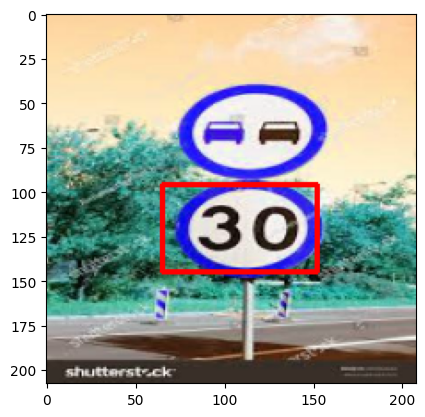

In [29]:
pred = 9
center_x = predictions_loc['x'][pred]
center_y = predictions_loc['y'][pred]
width = predictions_loc['w'][pred]
height = predictions_loc['h'][pred]
start_point = (int((center_x - width / 2) * 208), int((center_y - height / 2) * 208))
end_point = (int((center_x + width / 2) * 208), int((center_y + height / 2) * 208))
color = (255, 0, 0)
thickness = 2
plt.imshow(cv2.rectangle(raw_test_images[pred], start_point, end_point, color, thickness))

In [30]:
model.save('model.keras')